In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
from matplotlib import pyplot as plt
import joblib
from pathlib import Path
import sqlite3

In [38]:
connection = sqlite3.connect('../data/nba.db')


df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup', con=connection)
df = df.drop(columns=['index'])

connection.close()

df = df.sort_values('GAME_DATE')

df = df.dropna()

columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
       'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
       'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF', 'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE']

train_df = df.loc[df['SEASON'] < '2021-22']
test_df = df.loc[df['SEASON'] >= '2021-22']


X_train = train_df.drop(columns=columns_to_drop)
y_train = train_df['HOME_WL']

X_test = test_df.drop(columns=columns_to_drop)
y_test = test_df['HOME_WL']

train_df.shape, test_df.shape

((9721, 641), (1234, 641))

In [34]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

In [8]:
filename = 'SGDRegressor_ScorePredictor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_sgd_reg = joblib.load(model_location)

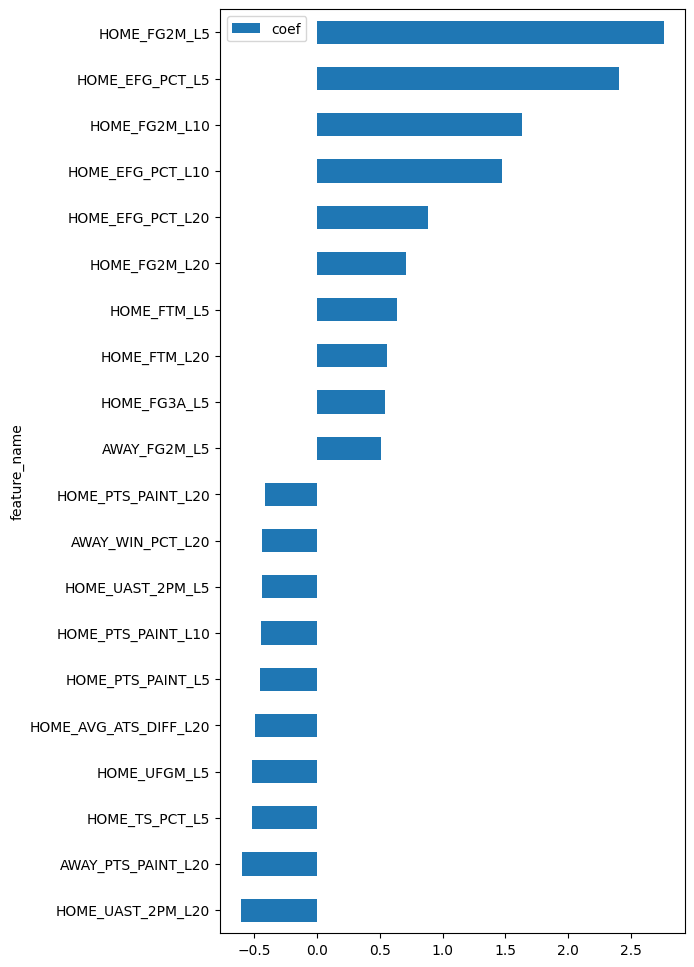

In [35]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[0], X_train)

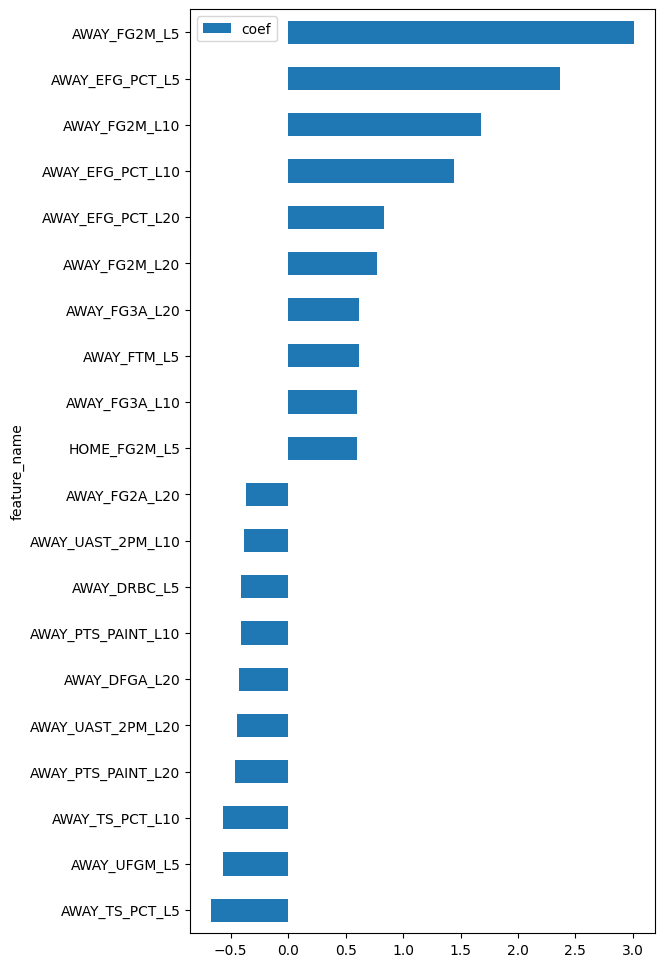

In [36]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[1], X_train)

In [37]:
pd.options.display.max_rows=650

sgd_coef_df.sort_values('coef', ascending=False)

,feature_name,coef
313,AWAY_FG2M_L5,3.011282
410,AWAY_EFG_PCT_L5,2.364058
417,AWAY_FG2M_L10,1.675870
514,AWAY_EFG_PCT_L10,1.442820
618,AWAY_EFG_PCT_L20,0.834847
521,AWAY_FG2M_L20,0.770327
524,AWAY_FG3A_L20,0.620018
317,AWAY_FTM_L5,0.611976
420,AWAY_FG3A_L10,0.596528
0,HOME_FG2M_L5,0.594969
